In [1]:
import numpy as np
from numpy import array, sin, cos, dot, random, zeros, ones, exp
from scipy.optimize import minimize, root
from scipy.linalg import solve, norm
from scipy.integrate import simps
from scipy.interpolate import lagrange
from math import pi
import sys
import matplotlib.pyplot as plt
from matplotlib import animation,rc
%matplotlib inline
from IPython.display import HTML
import matplotlib.pyplot as plt

## Mechanical System

In [2]:
#change here
#------------
Duration = 3;
FPS = 100;

#-----------
dt = 1./FPS
N = int(Duration*FPS);
friction = 1
g = 9.8

costs=[]

def acrobot_gradient(x, u):
    
    M = array([[3 + 2*cos(x[1]), 1+cos(x[1])],[1+cos(x[1]), 1]])
    c1 = x[3]*(2*x[2]+x[3])*sin(x[1]) - 2*g*sin(x[0]) - g*sin(x[0]+x[1])
    c2 = -x[2]**2*sin(x[1]) - g*sin(x[0]+x[1])
    a = np.concatenate([x[2:4], solve(M,array([c1-friction*x[2], c2-friction*x[3]]))])
    bottom=solve(M,array([[1,0],[0,1]]))
    B = array([[0,0],
               [0,0],
               [bottom[0,0],bottom[0,1]],
               [bottom[1,0],bottom[1,1]]])
    #print(u.shape)
    xd = a + dot(B,u)
    return xd
    
def acrobot_next_step(x,u):
    
    xd = acrobot_gradient(x,u)
    new_x = x + xd*dt
    #limit angle range to [0, 2pi]
    #new_x[0]=new_x[0]%(2*pi)
    #new_x[1]=new_x[1]%(2*pi)
    #avoid acceleration overflow
    return new_x#np.clip(new_x,-100,100)

r=0.0001
k=1
last_steps_bonus = 100
penalize_u1_factor = 1
def cost_function(x,u,i,n) : 
    if i >= (n-3):
        return r/2*(penalize_u1_factor*u[0]**2+u[1]**2) + 1 - last_steps_bonus*exp(-k*cos(x[0]) + k*cos(x[1])-2*k)
    else:
        return r/2*(penalize_u1_factor*u[0]**2+u[1]**2) + 1 - exp(-k*cos(x[0]) + k*cos(x[1])-2*k) 


#define partial derivation functions
def numerical_dfdxT(x,u):
    delta = 0.0001
    out = zeros([4,4])
    for i in range(4):
        delta_v = zeros(4)
        delta_v[i] = delta
        #print(x+delta_v)
        out[i] = ((acrobot_gradient(x+delta_v,u)-acrobot_gradient(x-delta_v,u))*dt+2*delta_v)/2/delta
    return out

def dfdxT(x,u):
    
    M = array([[3 + 2*cos(x[1]), 1+cos(x[1])],
               [1+cos(x[1]),    1]
              ])
    C = array([[-2*sin(x[1])*x[3], -sin(x[1])*x[3]],
               [sin(x[1])*x[2],    0]
              ])
    dGdq = array([[g*(2*cos(x[0])+cos(x[0]+x[1])),g*cos(x[0]+x[1])],
                  [g*cos(x[0]+x[1]),              g*cos(x[0]+x[1])]
                 ])
    bottom_left = - solve(M,dGdq)
    bottom_right = - solve(M,C+np.identity(2)*friction)
    xd= array([[0,0,1,0],
                  [0,0,0,1],
                  [bottom_left[0,0],bottom_left[0,1],bottom_right[0,0],bottom_right[0,1]],
                  [bottom_left[1,0],bottom_left[1,1],bottom_right[1,0],bottom_right[1,1]]
                 ])
    x = xd*dt+np.identity(4)
    return x.T

def dfdu(x,u):
    M = array([[3 + 2*cos(x[1]), 1+cos(x[1])],[1+cos(x[1]), 1]])
    bottom=solve(M,np.identity(2))
    B = array([[0,0],
               [0,0],
               [bottom[0,0],bottom[0,1]],
               [bottom[1,0],bottom[1,1]]])
    return dt*B


def dgdx(x,u,i,n):
    out = zeros(4)
    x1= x[0]
    x2= x[1]
    out[0] = -exp(-k*cos(x1)+k*cos(x2)-2*k)*k*sin(x1)
    out[1] = exp(-k*cos(x1)+k*cos(x2)-2*k)*k*sin(x2)
    
    if i >= (n-3):
        out *= last_steps_bonus
    return out
def dgdu(x,u):
    return r*array([u[0]*penalize_u1_factor,u[1]])


## Lagrangian multiplier derivation

In [3]:
def grad_lagrangian_trick(u):
    # u is a vector of u0 to uN-1
    n=len(u)//2
    
    u=np.reshape(u,[n,2])
    x = zeros([n+1,4])
    x[0]=starting_point
    lam = zeros([n,4])
    lam[n-1] = zeros(4)
    dldu = zeros([n,2])
    
    #calculate gradient through back propagation
    for i in range(n):
        x[i+1]=acrobot_next_step(x[i],u[i])
        
    for i in reversed(range(1,n)):
        lam[i-1]=dgdx(x[i],u[i],i,n)+dot(dfdxT(x[i],u[i]),lam[i])
    
    for i in range(n):
        dldu[i]=dgdu(x[i],u[i])+dot(lam[i],dfdu(x[i],u[i]))
    
    return np.reshape(dldu,n*2)

def lagrangian_root_train(dt,N):
    u = zeros([N*2])#random.normal(0,size=N)
    #print(u.shape)
    out = root(grad_lagrangian_trick,u) 
    print(lagrangian_trick(out.x))
    return (out,out.x.reshape([N,2]))

def lagrangian_trick(u):
    #x is x1 to xN,followed by U0 to UN-1, followed by lambda0 to lambdaN-1
        # u is a vector of u0 to uN-1
    n=len(u)//2
    
    u=np.reshape(u,[n,2])
    x = zeros([n+1,4])
    x[0]=starting_point
    lam = zeros([n,4])
    lam[n-1] = zeros(4)
    
    
    #calculate gradient through back propagation
    for i in range(n):
        x[i+1]=acrobot_next_step(x[i],u[i])
        
    for i in reversed(range(1,n)):
        lam[i-1]=dgdx(x[i],u[i],i,n)+dot(dfdxT(x[i],u[i]),lam[i])

    L=0
    U=0
    for i in range(n):
        #current x
        xx = x[i]
        #next x
        xx_p1 = x[i+1]
        #difference between x+dt*dx and x_next
        delta = xx+dt*acrobot_gradient(xx,u[i])-xx_p1
        #minimize energy
        cost = cost_function(xx,u[i],i,n)
        lagragian_term = dot(lam[i],delta)
        L+=cost#+lagragian_term
        U+= dot(u[i],u[i])
    print("L: "+str(L)+" U:"+str(r/2*U))
    costs.append(L)
    return L

def lagrangian_BFGS_train(dt,N,u=None, normal_seed=True):
    if u is None:
        u = random.normal(0,size=N*2) if normal_seed else zeros([N*2])
    #print(u.shape)
    out = minimize(lagrangian_trick,u,jac=grad_lagrangian_trick,options={"disp":True}) 
    return (out,out.x.reshape([N,2]))
def lagrangian_trick_train():
    init = np.ones(N*2)
    out = minimize(lagrangian_trick,init)
    return (out,out.x.reshape([N,2]))

In [4]:
#reset costs
costs=[]
#out = chebyshev_root_train(dt,N,3) 
#out = lagrangian_root_train(dt,N)

# stablize
starting_point = array([pi - 0.1,0,0,0])
u = zeros([N*2]).reshape([N, 2])
u[:30] = array([6, 2])
u[30:50] = array([0, -0.8])
u[50:90] = array([0, 0.1])

out = lagrangian_BFGS_train(dt,N, u)
u = out[1]
#out = chebyshev_BFGS_train(dt,N,20) 
#out = lagrangian_trick_train()

L: 127.464533969 U:0.06066
L: 97.3471546065 U:0.0603047307449
L: 149.786015781 U:0.0599037537246
L: 101.896068898 U:0.060050561577
L: -6.33511021052 U:0.0601825488215
L: 97.3212862164 U:0.0603042517691
L: 79.6646669763 U:0.0602199953829
L: 45.0394297025 U:0.0601941148879
L: -46.1417995149 U:0.0601859845592
L: -130.970176419 U:0.0601837751365
L: -118.9354476 U:0.060185329041
L: -291.745454472 U:0.0601844896113
L: -291.451738683 U:0.0601844582332
L: -291.803360408 U:0.0601844804839
L: -291.803357173 U:0.0601844806244
L: 191.38045344 U:0.13190753042
L: 153.900702381 U:0.0648022586714
L: 91.4233484416 U:0.0603372563453
L: -277.328211512 U:0.0601848788375
L: -291.803370577 U:0.0601844808321
L: -291.80339766 U:0.0601844817581
L: -291.803505989 U:0.0601844854622
L: -291.803939293 U:0.0601845002785
L: -291.805672321 U:0.0601845595438
L: -291.812601436 U:0.0601847966062
L: -291.840269886 U:0.0601857448786
L: -291.950175134 U:0.0601895383265
L: -292.377471545 U:0.0602047178561
L: -293.887785617 

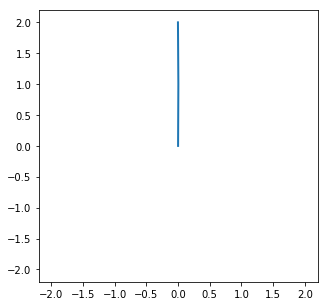

In [5]:
#u = zeros(N)
def simulation(x,u):
    x = np.zeros((N, 4))
    x[0] = starting_point
    for i in range(N-1):
        x[i+1] = acrobot_next_step(x[i], u[i])
        x[i+1][0]=x[i+1][0]%(2*pi)
        x[i+1][1]=x[i+1][1]%(2*pi)
    return x

x = np.zeros((N, 4))
x[0] = starting_point

x = simulation(x,u)

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(5,5))

ax.set_xlim(( -2.2, 2.2))
ax.set_ylim((-2.2, 2.2))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(k):
    x1 = cos(x[k,0]-pi/2);
    y1 = sin(x[k,0]-pi/2);
    x2 = x1 + cos(x[k,0]+x[k,1]-pi/2);
    y2 = y1 + sin(x[k,0]+x[k,1]-pi/2);
    
    xs = [0, x1, x2]
    ys = [0, y1, y2]
    line.set_data(xs, ys)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=N, interval=20, blit=True)
HTML(anim.to_html5_video())

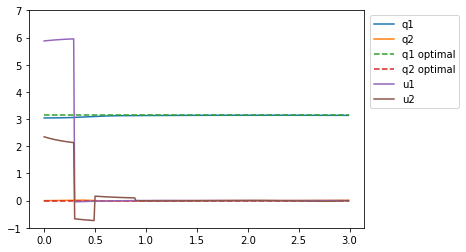

In [6]:
ts = np.arange(N)*dt
plt.plot(ts,x[:,0],label="q1")
q2 =array([q_2 - (2*pi)*(q_2>pi) for q_2 in x[:, 1]])

plt.plot(ts,q2,label="q2")
plt.plot(ts,ones(N)*pi,"--",label="q1 optimal")
plt.plot(ts,zeros(N),"--",label="q2 optimal")
plt.plot(ts,u[:,0],label="u1")
plt.plot(ts,u[:,1],label="u2")
plt.legend(loc = 1, bbox_to_anchor=(1.3, 1))
plt.ylim([-1, 7])
# plt.title("full-actuated swing up")
plt.show()

In [23]:
#reset costs
costs=[]

# swing-up
starting_point = array([0,0,0,0])

u = zeros([N*2]).reshape([N, 2])
u[:40] = array([50, 0])
u[40:60] = array([13, -4 ])
u[60:80] = array([-2, -4])
u[80:100] = array([-1,-4])
u[100:110] = array([-1, -2.4])
out = lagrangian_BFGS_train(dt,N, u)
u = out[1]
#out = chebyshev_BFGS_train(dt,N,20) 
#out = lagrangian_trick_train()

L: 41.677637006 U:5.22538
L: 119.509318844 U:5.22926073352
L: 39.4056608838 U:5.22638086121
L: 20.0965169743 U:5.22578447554
L: 88.8175604216 U:5.21351285391
L: 13.347719008 U:5.2245594229
L: 5.39273572741 U:5.22126999492
L: -1.47063977857 U:5.21510233904
L: -30.017977666 U:5.19059414667
L: 67.1511635927 U:5.09516027527
L: -29.976005101 U:5.16765412274
L: -66.6290983048 U:5.14960957043
L: -152.221591254 U:5.12169227186
L: 123.677385803 U:5.09754809939
L: -223.622242563 U:5.12075571112
L: 77.2917741909 U:5.12840330217
L: -226.111997688 U:5.12079818588
L: -226.120204683 U:5.12079835041
L: 48.2061911327 U:5.12459603156
L: -226.659906523 U:5.12080972467
L: -226.662347916 U:5.12080977888
L: -25.0087755173 U:5.12270171375
L: -226.832426508 U:5.12081362699
L: -226.833279387 U:5.12081364666
L: -128.619962674 U:5.12175738355
L: -226.917997934 U:5.12081561934
L: -226.918438666 U:5.12081562971
L: -200.393444532 U:5.12128643278
L: -226.994615257 U:5.1208174378
L: -226.995019057 U:5.12081744748
L: 

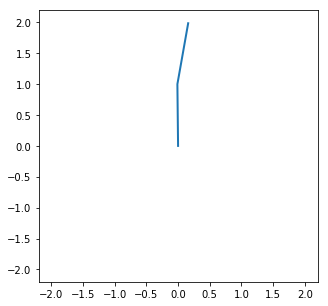

In [24]:
x = np.zeros((N, 4))
x[0] = starting_point

x = simulation(x,u)

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(5,5))

ax.set_xlim(( -2.2, 2.2))
ax.set_ylim((-2.2, 2.2))

line, = ax.plot([], [], lw=2)


# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=N, interval=20, blit=True)
HTML(anim.to_html5_video())

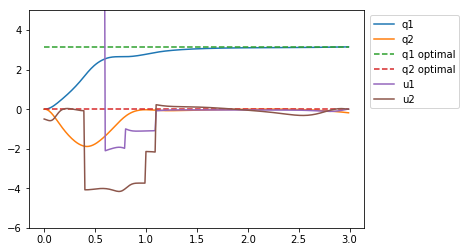

In [25]:
ts = np.arange(N)*dt
plt.plot(ts,x[:,0],label="q1")
q2 =array([q_2 - (2*pi)*(q_2>pi) for q_2 in x[:, 1]])

plt.plot(ts,q2,label="q2")
plt.plot(ts,ones(N)*pi,"--",label="q1 optimal")
plt.plot(ts,zeros(N),"--",label="q2 optimal")
plt.plot(ts,u[:,0],label="u1")
plt.plot(ts,u[:,1],label="u2")
plt.legend(loc = 1, bbox_to_anchor=(1.3, 1))
plt.ylim([-6, 5])
# plt.title("full-actuated swing up")
plt.show()